### Nested Clustered Optimization

Nested Clustered Optimization은 wrapper라고 알려진 알고리즘의 종류에 속한다. 어떤 효율적 경계의 구성 원소가 계산되는지 여부나 어떤 제약 조건들이 부과되는지 여부에 대래서 무관하다. NCO는 마코위츠의 저주가 기존의 평균-분산 배분 방법에 미치는 영향을 해결하기 위한 전략을 제공한다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import warnings

warnings.filterwarnings('ignore')

TICKERS = pd.read_excel('S&P500_ticker_list.xlsx')['Symbol'].tolist()
START_DATE = '2010-01-01'
END_DATE = pd.to_datetime('today')

data = yf.download(
    TICKERS,
    start = START_DATE,
    end = END_DATE,
    progress = False,
    interval = '1d'
)['Close']

In [2]:
data = data.resample('W').last().dropna(axis = 1)
ret = data.pct_change().dropna()

#### 상관 군집화

NCO알고리즘의 첫 번째 단계는 상관 행렬을 군집화하는 것이다. 이 작업에는 최적의 군집 수를 찾는 작업이 포함된다. 한가지 가능성은 ONC알고리즘을 적용하는 것이지만, NCO는 군집 수를 결정하는 데 사용되는 어떤 알고리즘이 사용되는가에 대해서 무관하다. $\frac{T}{N}$이 상대적으로 낮은 큰 행렬의 경우 Dimension Reduction에서 설명한 방법에 따라 군집화 전에 상관 행렬의 잡음을 제거하는 것이 바람직하다. 아래의 코드는 이 절차를 구현한다. 

In [3]:
from FinancialMachineLearning.utils.stats import *
from FinancialMachineLearning.machine_learning.clustering import *

nBlocks, bSize, bCorr, q  = 3, 2, .5, 10
cov0 = ret.cov()

In [4]:
corr0 = covariance_to_correlation(cov0)
eVal0, eVec0 = getPCA(corr0)
eMax0, var0 = find_max_eval(np.diag(eVal0), q, bWidth = 0.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)
corr1 = denoise_target_shrinkage(eVal0, eVec0, nFacts0)  # denoising by constant residual eigenvalue method
cov1 = correlation_to_covariance(corr1, np.diag(cov0) ** .5)

In [5]:
cov1 = pd.DataFrame(cov1, index = cov0.index, columns = cov0.columns)

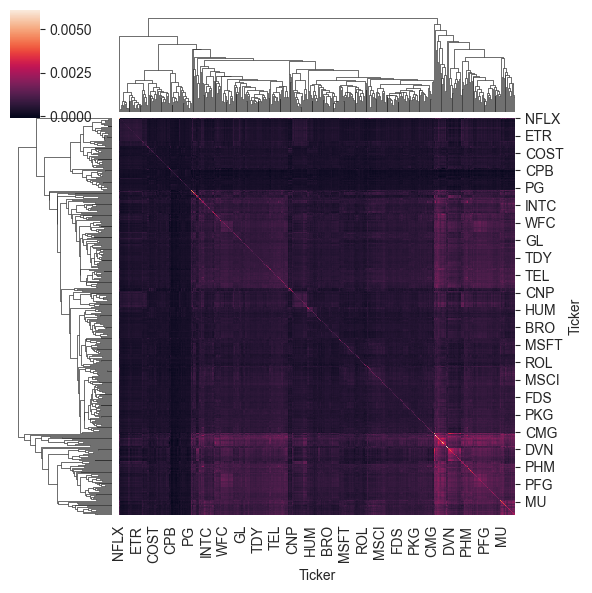

In [6]:
sns.clustermap(cov1, figsize = (6, 6))
plt.show()

In [7]:
corr1 = covariance_to_correlation(cov1)
corr1, clusters1, silh = clusterKMeansBase(
    corr1, 
    maxNumClusters = int(corr0.shape[0] / 2),
    n_init = 10
)

#### 군집 내 비중

NCO알고리즘의 두 번째 단계는 잡음이 제거된 공분산 행렬을 사용해 최적의 군집 내 배분을 계산하는 것이다. 아래의 코드는 이 절차를 구현한다. 단순성을 위해 배분 방법은 최소 분산 배분을 보여주나, 이 절차는 다른 대체적인 배분 방법의 사용도 허용한다. 추정된 군집 내 가중치를 사용해 군집 간 상관관계를 나타내는 축약된 공분산 행렬을 도출할 수 있다.

In [ ]:
wIntra = pd.DataFrame(0, index = cov1.index, columns = clusters1.keys())
for i in clusters1 :
    wIntra.loc[clusters1[i], i] = optimizing_portfolio(cov1.loc[clusters1[i], clusters1[i]]).flatten()
cov2 = wIntra.T.dot(np.dot(cov1, wIntra))

In [ ]:
print(cov2)

#### 군집 간 비중

NCO 알고리즘의 세 번째 단계는 축약된 공분산 행렬을 사용해 최적의 군집 간 배분을 계산하는 것이다. 구성상 이 공분산 행렬은 대각 행렬에 가깝고, 최적화 문제는 이상적인 Markowitz 사례에 가깝다. 즉 군집화와 군집 내 최적화 단계를 통해 Markowitz-cursed 문제를 올바르게 작동하는 문제로 전환할 수 있다. 아래의 코드는 이 절차를 구현한다. 군집 내 배분 단계에서 사용된 것과 동일한 배분 절차를 적용한다. 증권당 최종 배분은 Dataframe에 의해 표현되며, 이는 군집 내 비중과 군집 간 비중을 곱한 결과로 나타난다.

In [10]:
winter = pd.Series(optimizing_portfolio(cov2).flatten(), index = cov2.index)

In [11]:
print(winter)

0    0.541928
1    0.026487
2    0.431585
dtype: float64


In [12]:
wAII0 = wIntra.mul(winter, axis = 1).sum(axis = 1).sort_index()

In [13]:
ret.mean()

Ticker
A       0.003077
AAL     0.003706
AAPL    0.005180
ABT     0.002334
ACGL    0.004041
          ...   
XEL     0.001832
XOM     0.001239
YUM     0.002716
ZBH     0.001368
ZBRA    0.004440
Length: 433, dtype: float64

### Monte Carlo Simulation

이번 절에서는 NCO 알고리즘을 통제된 실험에 적용하고, 그 성능을 마코위츠의 접근법과 비교한다. Denosing과 Detoning에서 다뤘던 것과 마찬가지로 제약 없는 Efficient Frontier의 어떤 구성 포트폴리오도 Efficient Frontier의 두 가지 특성 포트폴리오, 즉 최소 분산 포트폴리오와 최대 샤프 비율 포트폴리오의 볼록 조합으로 도출될 수 있기 때문에 이들에 대해 논의한다.

아래의 코드는 앞서 소개한 NCO 알고리즘을 구현한다. 인수 mu가 None이면 최소 분산 포트폴리오를 반환하는 반면, mu가 None이 아닌 경우 `nested_clustered_optimization`함수는 최대 샤프 비율 포트폴리오를 반환한다.

In [16]:
print(nested_clustered_optimization(
    cov = cov1,
    mu = None, # minimize variance
    maxNumClusters = 3
)[:5])

[[-0.01404696]
 [ 0.00079059]
 [ 0.00323021]
 [-0.00623099]
 [ 0.01733676]]


#### 1. Minimized Variance Portfolio

아래의 코드는 50개 증권 포트폴리오의 전형적 버전을 나타내는 랜덤 평균 벡터와 랜덤 공분산 행렬을 생성하며, 군집 내 상관관계가 0.5인 10개의 블록으로 그룹화한다. 이 벡터와 행렬은 관측치를 생성하는 '실제' 프로세스의 특성을 나타낸다. 다른 parameter를 사용해 여러 시행 결과를 재현하고 비교하기 위한 seed를 설정했다. 

In [17]:
def from_block_matrix(num_of_blocks, block_size, block_corr) :
    block = np.ones((block_size, block_size)) * block_corr
    block[range(block_size), range(block_size)] = 1
    corr = block_diag(*([block] * num_of_blocks))
    return corr

def from_true_matrix(num_of_blocks, block_size, block_corr) :
    corr0 = from_block_matrix(num_of_blocks, block_size, block_corr)
    corr0 = pd.DataFrame(corr0)
    cols = corr0.columns.tolist()
    np.random.shuffle(cols)
    corr0 = corr0[cols].loc[cols].copy('deep')
    std0 = np.random.uniform(0.05, 0.2, corr0.shape[0])
    cov0 = correlation_to_covariance(corr0, std0)
    mu0 = np.random.normal(
        std0,
        std0,
        cov0.shape[0]
    ).reshape(-1, 1)
    return mu0, cov0

In [18]:
n_blocks, block_size, block_corr = 10, 50, 0.5
np.random.seed(0)
mu0, cov0 = from_true_matrix(n_blocks, block_size, block_corr)

아래의 코드는 `simulation_cov_mu` 함수를 사용해 실제 프로세스에서 도출된 1,000개의 관측치를 기반으로 랜덤 경험적 평균 벡터와 랜덤 경험적 공분산 행렬은 Ledoit wolf shrinkage를 따른다. 경험적 공분산 행렬을 사용해 함수 `optimizing_portfolio`는 Markwitz에 따른 MVO를 추정하며, 함수 `nested_clustered_optimization`은 NCO알고리즘을 적용해 MVO를 추정한다. 이 절차는 1,000개의 서로 다른 랜덤 경험적 공분산 행렬에 반복된다. `minVarPortf=True`이면 랜덤 경험적 평균 백터는 사용되지 않는다는 점을 주목하자.

In [19]:
def simulation_cov_mu(mu0, cov0, num_obs, shrink = False) :
    x = np.random.multivariate_normal(mu0.flatten(), cov0, size = num_obs)
    mu1 = x.mean(axis = 0).reshape(-1, 1)
    if shrink : 
        cov1 = LedoitWolf().fit(x).covariance_
    else : 
        cov1 = np.cov(x, rowvar = 0)
    return mu1, cov1

In [21]:
from tqdm import tqdm

w1 = pd.Series(dtype = float)
w1_d = pd.Series(dtype = float)

num_obs, num_simulations, shrink, minVarPortf = 100, 100, False, True
np.random.seed(0)
for i in tqdm(range(num_simulations)):
    mu1, cov1 = simulation_cov_mu(mu0, cov0, num_obs, shrink = shrink)
    if minVarPortf :
        mu1 = None
    w1.loc[i] = optimizing_portfolio(cov1, mu1).flatten()
    w1_d.loc[i] = nested_clustered_optimization(cov1, mu1, int(cov1.shape[0] / 2)).flatten()

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "/opt/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/numpy/core/multiarray.py", line 346, in where
    @array_function_from_c_func_and_dispatcher(_multiarray_umath.where)
KeyboardInterrupt: 
  0%|          | 0/100 [07:20<?, ?it/s]


KeyboardInterrupt: 

In [26]:
import multiprocessing as mp

def run_simulation(args):
    i, mu0, cov0, num_obs, shrink, minVarPortf = args
    mu1, cov1 = simulation_cov_mu(mu0, cov0, num_obs, shrink=shrink)
    if minVarPortf:
        mu1 = None
    w1 = optimizing_portfolio(cov1, mu1).flatten()
    w1_d = nested_clustered_optimization(cov1, mu1, int(cov1.shape[0] / 2)).flatten()
    return w1, w1_d

def parallel_simulation(mu0, cov0, num_obs, num_simulations, shrink, minVarPortf):
    mp.set_start_method('fork', force=True)
    with mp.Pool(processes = mp.cpu_count()) as pool:
        args = [(i, mu0, cov0, num_obs, shrink, minVarPortf) for i in range(num_simulations)]
        results = list(tqdm(pool.imap(run_simulation, args), total=num_simulations))
    
    w1 = pd.DataFrame([r[0] for r in results]).T
    w1_d = pd.DataFrame([r[1] for r in results]).T
    return w1, w1_d

In [27]:
if __name__ == '__main__':
    num_obs, num_simulations, shrink, minVarPortf = 100, 100, False, True
    np.random.seed(0)
    
    n_blocks, block_size, block_corr = 10, 50, 0.5
    mu0, cov0 = from_true_matrix(n_blocks, block_size, block_corr)
    
    w1, w1_d = parallel_simulation(mu0, cov0, num_obs, num_simulations, shrink, minVarPortf)
    
    print("Simulation completed.")
    print("w1 shape:", w1.shape)
    print("w1_d shape:", w1_d.shape)

  0%|          | 0/100 [00:00<?, ?it/s]Process SpawnPoolWorker-241:
Process SpawnPoolWorker-244:
Process SpawnPoolWorker-242:
Process SpawnPoolWorker-246:
  0%|          | 0/100 [00:38<?, ?it/s]Process SpawnPoolWorker-245:
Process SpawnPoolWorker-243:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/FinancialMachineLearning/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/FinancialMachineLearning/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/FinancialMachineLearning/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/anaconda3/envs/FinancialMachineLearning/lib/python3.10/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/opt/anaconda3/envs/FinancialMachineLearning/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__e

KeyboardInterrupt: 

아래의 코드는 실제 공분산 행렬에서 파생된 실제 최소 분산 포트폴리오를 계산한다. 그런 배분을 벤치마크로 사용해 모든 비중에 대한 RMSE를 계산한다. 아래의 코드를 shrinkage한 경우와 아닌 경우를 실행할 수 있으므로, 표에 표시된 네 가지 조합을 얻을 수 있다.

In [28]:
w0 = optimizing_portfolio(cov0, None if minVarPortf else mu0)
w0 = np.repeat(w0.T, w1.shape[0], axis = 0)
rmse = np.mean((w1 - w0).values.flatten() ** 2)**0.5 # RMSE
rmse_d = np.mean((w1_d - w0).values.flatten() ** 2)**0.5 # RMSE

ValueError: Data must be 1-dimensional, got ndarray of shape (1, 500) instead